In [2]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
seed=42

In [3]:
#loading image data
imageData=[]

for filename in os.listdir('Train/'):
    imageData.append(img_to_array(load_img('Train/'+filename)))

imageData=np.array(imageData,dtype=float)
imageData=imageData/255.    

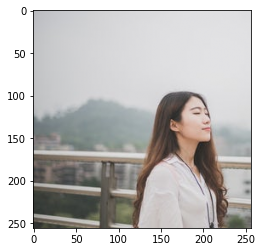

In [4]:
plt.imshow(imageData[0])

In [5]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()

225214464/225209952 [==============================] - 110s 0us/step


In [6]:
input_shape=(256,256,1)

In [7]:
#encoder
encoder_input=Input(shape=input_shape)


conv1=Conv2D(64,(3,3),activation='relu',padding='same',strides=2)(encoder_input)
conv1=Conv2D(64,(3,3),activation='relu',padding='same')(conv1)
batch_norm1=BatchNormalization()(conv1)

conv2=Conv2D(128,(3,3),activation='relu',padding='same',strides=2)(batch_norm1)
conv2=Conv2D(128,(3,3),activation='relu',padding='same')(conv2)
batch_norm2=BatchNormalization()(conv2)

conv3=Conv2D(256,(3,3),activation='relu',padding='same',strides=2)(batch_norm2)
conv3=Conv2D(256,(3,3),activation='relu',padding='same')(conv3)
batch_norm3=BatchNormalization()(conv3)

conv4=Conv2D(512,(3,3),activation='relu',padding='same')(batch_norm3)
conv4=Conv2D(512,(3,3),activation='relu',padding='same')(conv4)
batch_norm4=BatchNormalization()(conv4)

conv5=Conv2D(256,(3,3),activation='relu',padding='same')(batch_norm4)
conv5=Conv2D(256,(3,3),activation='relu',padding='same')(conv5)

print(conv5.shape)

(None, 32, 32, 256)


<h5>The inception network gives us a 1000*1 dimensional vector which gives us the probability of an image belonging to particular class. We will repeat this vector 32*32 (conv5 layer output dimension) times to creat a 32*32 dimensional layer with 1000 channels which will give us the probability of a pixel belonging to a particular class and hence the color of that class</h5>

In [8]:
embed_input=Input(shape=(1000,))


#fusion
fusion_output=RepeatVector(1024)(embed_input)
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([conv5, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)


In [9]:
#decoder

conv6=Conv2D(128,(3,3),activation='relu',padding='same')(fusion_output)
conv6=Conv2D(128,(3,3),activation='relu',padding='same')(conv6)
batch_norm_decoder1=BatchNormalization()(conv6)
upsample1=UpSampling2D((2,2))(batch_norm_decoder1)

conv7=Conv2D(64,(3,3),activation='relu',padding='same')(upsample1)
conv7=Conv2D(64,(3,3),activation='relu',padding='same')(conv7)
batch_norm_decoder2=BatchNormalization()(conv7)
upsample2=UpSampling2D((2,2))(batch_norm_decoder2)

conv8=Conv2D(32,(3,3),activation='relu',padding='same')(upsample2)
conv8=Conv2D(32,(3,3),activation='relu',padding='same')(conv8)
batch_norm_decoder3=BatchNormalization()(conv8)

conv9=Conv2D(16,(3,3),activation='relu',padding='same')(batch_norm_decoder3)
conv10=Conv2D(2,(3,3),activation='tanh',padding='same')(conv9)

decoder_output=UpSampling2D((2,2))(conv10)


alpha_model=Model(inputs=[encoder_input,embed_input],outputs=decoder_output)

In [10]:
# from keras.utils.vis_utils import plot_model
# import pydot
# tf.keras.utils.plot_model(inception, to_file='dot_img_file.png', show_shapes=True)

In [11]:
alpha_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_203[0][0]                 
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 128, 128, 64) 256         conv2d_204[0][0]                 
______________________________________________________________________________________________

<h4>
To create a fusion layer input,we have to create inception network embedding
which is given as an input to the fusion layer to concatenate with encoder output
</h4>

In [12]:
def createInceptionEmbedding(image_grayscale):
    # data : grayscaled rgb image resized
    data=[]
    for image in image_grayscale:
        image=resize(image,(299,299,3),mode='constant')
        data.append(image)
    data=np.array(data)
    # preprocessing the data in accordance with inception network
    data=preprocess_input(data)
    #print(data.shape)
    embed=inception.predict(data)
    #print(embed.shape)
    return embed

In [13]:
bb=[imageData[0]]
bb=np.array(bb)
check=createInceptionEmbedding(gray2rgb(rgb2gray(bb)))

In [14]:
datagen=ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)
batch_size=8

In [15]:
def lab_image_gen(batch_size=8,x_train=imageData):
    for batch in datagen.flow(x_train,batch_size=batch_size):
        inception_input=gray2rgb(rgb2gray(batch))
        embed=createInceptionEmbedding(inception_input)
        
        lab_batch=rgb2lab(batch)
        X=lab_batch[:,:,:,0]
        Y=lab_batch[:,:,:,1:]/128
        X=X.reshape(X.shape+(1,))
        
        yield ([X, createInceptionEmbedding(inception_input)], Y)


In [16]:
alpha_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])
alpha_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_203[0][0]                 
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 128, 128, 64) 256         conv2d_204[0][0]                 
______________________________________________________________________________________________

In [107]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,monitor='loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_model.h5',min_lr=0.001,save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,patience=5,monitor='loss')
]

In [48]:
steps=imageData.shape[0]//batch_size
epochs=100

In [49]:
history=alpha_model.fit(lab_image_gen(batch_size,imageData),epochs=epochs,verbose=1,steps_per_epoch=steps,shuffle=True,callbacks=my_callbacks)

Epoch 1/100
105/105 [==============================] - 93s 897ms/step - loss: 0.0094 - mse: 0.0094
Epoch 2/100
105/105 [==============================] - 93s 886ms/step - loss: 0.0092 - mse: 0.0092
Epoch 3/100
105/105 [==============================] - 94s 892ms/step - loss: 0.0092 - mse: 0.0092
Epoch 4/100
105/105 [==============================] - 93s 888ms/step - loss: 0.0091 - mse: 0.0091
Epoch 5/100
105/105 [==============================] - 93s 888ms/step - loss: 0.0091 - mse: 0.0091
Epoch 6/100
105/105 [==============================] - 93s 883ms/step - loss: 0.0091 - mse: 0.0091
Epoch 7/100
105/105 [==============================] - 93s 887ms/step - loss: 0.0091 - mse: 0.0091
Epoch 8/100
105/105 [==============================] - 93s 884ms/step - loss: 0.0089 - mse: 0.0089
Epoch 9/100
105/105 [==============================] - 93s 888ms/step - loss: 0.0088 - mse: 0.0088
Epoch 10/100
105/105 [==============================] - 93s 888ms/step - loss: 0.0089 - mse: 0.0089
Epoch 11/

In [50]:
def plotAccuracyAndLoss(history):
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
#     plt.savefig('./')

    # loss plot
#     plt.plot(history.history['loss'])
    plt.plot(history.history['mse'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
    plt.legend(['loss'],loc='upper left')
#     plt.savefig('./')
    plt.show()

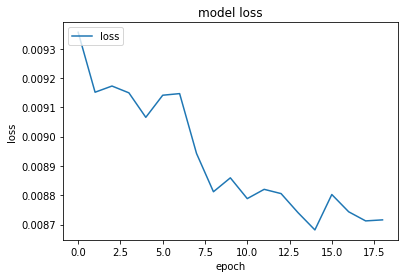

In [51]:
plotAccuracyAndLoss(history)

In [98]:
train_subset=imageData[100:136]
original=train_subset
gray_subset=gray2rgb(rgb2gray(train_subset))
train_subset_embed=createInceptionEmbedding(gray_subset)
train_subset=rgb2lab(train_subset)[:,:,:,0]
train_subset=train_subset.reshape(train_subset.shape+(1,))

output_subset=alpha_model.predict([train_subset,train_subset_embed])
output_subset=output_subset*128


In [99]:
def plot_imgs(bw , arr):
#     defect_files = train['File'][train["Disease Type"]==distype].values
    n = 0
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    i=0
    for i in range(len(arr)):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        i=i+1
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = bw[i-1][:,:,0]
        cur[:,:,1:] = arr[i-1]
        cur=lab2rgb(cur)
        plt.imshow(cur,cmap='gray')
    plt.show()

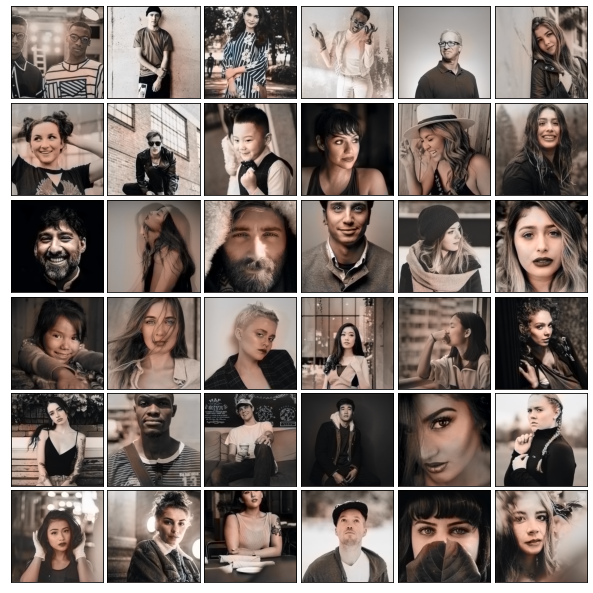

In [100]:
plot_imgs(train_subset,output_subset)

In [105]:
def plot_original_imgs(original):
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(len(original)):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        i=i+1
        img=original[i-1]
        plt.imshow(img,cmap='gray')
    plt.show()

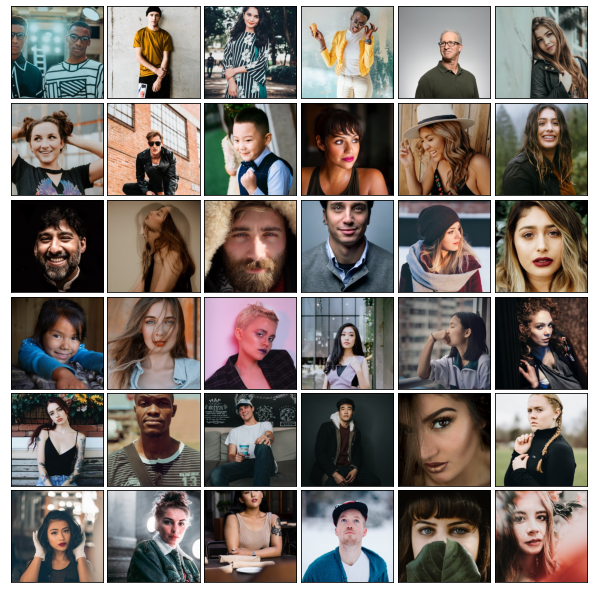

In [106]:
plot_original_imgs(original)

In [114]:
#Saving Model
alpha_model.save('Alpha_Model_Brownish_Output.h5')
alpha_model_json = alpha_model.to_json()
with open("alpha_model.json", "w") as json_file:
    json_file.write(alpha_model_json)

In [117]:
#testing

color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
original_test=color_me/255.
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = createInceptionEmbedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = alpha_model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
# for i in range(len(output)):
#     cur = np.zeros((256, 256, 3))
#     cur[:,:,0] = color_me[i][:,:,0]
#     cur[:,:,1:] = output[i]
#     imsave("result/img_"+str(i)+".png", lab2rgb(cur))

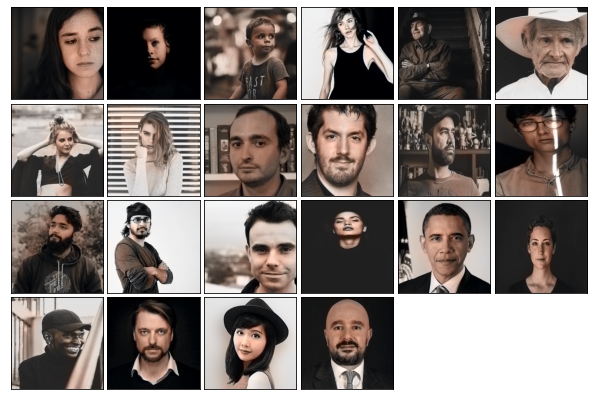

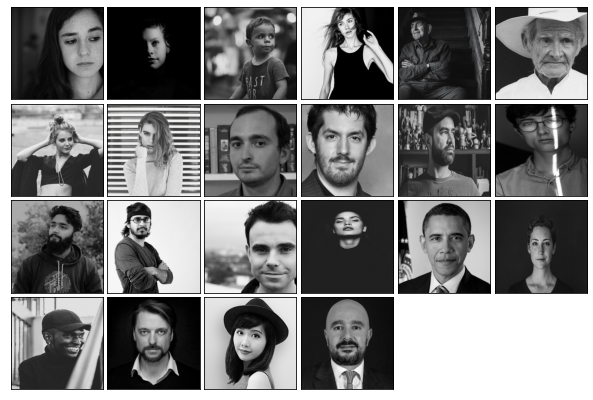

In [120]:
plot_imgs(color_me[0:36],output[0:36])
plot_original_imgs(original_test[0:36])